# CS 363M Project

## Names: Gabby Galicinao, Andrea Toba, Angela Cheng, Ruchi Shah

## The Problem ##
Movies are one of the most popular sources of entertainment and affect a country's society and culture. We will analyze this data to gain a better understanding of the factors that make movies well received by their audiences. These results can be used by both movie producers, who can better understand the factors needed to create a great movie, and their audiences, who can better predict if certain movies are worth watching.
<br>
In this project, we will attempt to classify movies by their IMDb scores, using the Movie Industry dataset (https://www.kaggle.com/datasets/danielgrijalvas/movies). In the initial dataset, there are 7,668 records and 15 attributes (some categorical, some continuous).

<br>**Currently our features include:** 
<br>name. Name of the film
<br>rating. G, PG, PG-13, R
<br>genre. comedy, action, etc.
<br>year. Release year
<br>released. Date of release, including the month, day, and year
<br>votes. Count of IMDb user votes
<br>director. Name of director of the film
<br>writer. Name of the writer of the film
<br>star. The main actor/actress of the film
<br>country. The film's country of origin
<br>budget. Amount of money used to create the film.
<br>gross. Amount of money made from the film.
<br>company. Name of production company
<br>runtime. Length of film in minutes.

<br>score. IMDb score that we are trying to predict (label)

## Data Cleaning

In [1]:
# Headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import square, sqrt
from pandas import DataFrame
import sklearn

In [2]:
missing_values = ["Not Rated", "Unrated", "Approved"]

In [3]:
data = pd.read_csv('movies.csv', header='infer', na_values=missing_values, skipinitialspace=True)
data

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,More to Life,NaN,Drama,2020,"October 23, 2020 (United States)",3.1,18.0,Joseph Ebanks,Joseph Ebanks,Shannon Bond,United States,7000.0,NaN,NaN,90.0
7664,Dream Round,NaN,Comedy,2020,"February 7, 2020 (United States)",4.7,36.0,Dusty Dukatz,Lisa Huston,Michael Saquella,United States,NaN,NaN,Cactus Blue Entertainment,90.0
7665,Saving Mbango,NaN,Drama,2020,"April 27, 2020 (Cameroon)",5.7,29.0,Nkanya Nkwai,Lynno Lovert,Onyama Laura,United States,58750.0,NaN,Embi Productions,NaN
7666,It's Just Us,NaN,Drama,2020,"October 1, 2020 (United States)",NaN,NaN,James Randall,James Randall,Christina Roz,United States,15000.0,NaN,NaN,120.0


In [4]:
print("Total missing values:", data.isnull().sum().sum())
print("\nTotal missing budget values:", data['budget'].isnull().sum().sum())

Total missing values: 2809

Total missing budget values: 2171


Since we're missing so many budget values, we decided that it was not reasonable to impute those missing values. Additionally, we plan to create a new feature using the budget feature, so using imputed (fake) data would produce inaccurate results.
<br>
Since we will still have a sufficient number of records without those with missing budget values, we decided that we can afford to drop them.

In [5]:
data.dropna(inplace=True)
# data.drop_duplicates(inplace=True)
print("Total number of records after drop:", data.shape[0])

Total number of records after drop: 5359


In [6]:
labels = data['score']
data = data.drop(columns=['name', 'score'])
data

,rating,genre,year,released,votes,director,writer,star,country,budget,gross,company,runtime
0,R,Drama,1980,"June 13, 1980 (United States)",927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,R,Adventure,1980,"July 2, 1980 (United States)",65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,PG,Action,1980,"June 20, 1980 (United States)",1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,PG,Comedy,1980,"July 2, 1980 (United States)",221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,R,Comedy,1980,"July 25, 1980 (United States)",108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7646,R,Drama,2020,"February 28, 2020 (United States)",186000.0,Leigh Whannell,Leigh Whannell,Elisabeth Moss,Canada,7000000.0,143151000.0,Universal Pictures,124.0
7648,R,Action,2020,"January 17, 2020 (United States)",140000.0,Adil El Arbi,Peter Craig,Will Smith,United States,90000000.0,426505244.0,Columbia Pictures,124.0
7649,PG,Action,2020,"February 14, 2020 (United States)",102000.0,Jeff Fowler,Pat Casey,Ben Schwartz,United States,85000000.0,319715683.0,Paramount Pictures,99.0
7650,PG,Adventure,2020,"January 17, 2020 (United States)",53000.0,Stephen Gaghan,Stephen Gaghan,Robert Downey Jr.,United States,175000000.0,245487753.0,Universal Pictures,101.0


In [7]:
labels

0       8.4
1       5.8
2       8.7
3       7.7
4       7.3
       ... 
7646    7.1
7648    6.6
7649    6.5
7650    5.6
7651    6.8
Name: score, Length: 5359, dtype: float64

## Data Exploration 

<AxesSubplot:title={'center':'Distribution of dataset by votes'}, ylabel='Frequency'>

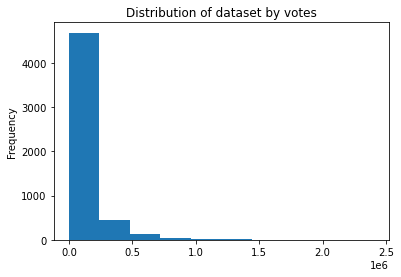

In [8]:
data['votes'].plot(kind='hist', title='Distribution of dataset by votes')

In [9]:
data['votes'].describe().apply("{0:.2f}".format)

count       5359.00
mean      115823.93
std       185011.57
min          195.00
25%        19000.00
50%        53000.00
75%       131000.00
max      2400000.00
Name: votes, dtype: object

We noticed that the distribution of votes was highly skewed. One idea that we had was to bin the data depending on the number of votes. We also considered dropping the outlier values, however those records could potentially have an impact on their IMDb score, so they would not be anomalous and would be useful.

In [10]:
# Examine correlations between continuous values
data.corr()

,year,votes,budget,gross,runtime
year,1.000000,0.207662,0.330342,0.275968,0.073406
votes,0.207662,1.000000,0.439428,0.615622,0.358178
budget,0.330342,0.439428,1.000000,0.739373,0.323501
gross,0.275968,0.615622,0.739373,1.000000,0.279794
runtime,0.073406,0.358178,0.323501,0.279794,1.000000


There is a strong positive correlation between budget and gross. There is a moderate positive correlation between votes and gross.

In [11]:
# # Plot correlation between budget and gross (scaled)
# # data.plot.scatter(x='budget', y='gross')
# plt.scatter(x=data['budget'], y=data['gross'])
# # plt.yticks(np.arange(0, 3e9, step=1e9))
# plt.show()

## Feature Engineering 

To Do:
<br>create profits column (gross - budget)
<br>get month and day from released
<br>one-hot encode categorical columns (?)
<br>modifying other categorical values (i.e., binning votes; changing rating to 0,1,2,3; etc.)

In [12]:
# Create profits column
data['profits'] = data['gross'] - data['budget']
data = data.drop(columns=['gross'])
data.head()

,rating,genre,year,released,votes,director,writer,star,country,budget,company,runtime,profits
0,R,Drama,1980,"June 13, 1980 (United States)",927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,Warner Bros.,146.0,27998772.0
1,R,Adventure,1980,"July 2, 1980 (United States)",65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,Columbia Pictures,104.0,54353106.0
2,PG,Action,1980,"June 20, 1980 (United States)",1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,Lucasfilm,124.0,520375067.0
3,PG,Comedy,1980,"July 2, 1980 (United States)",221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,Paramount Pictures,88.0,79953539.0
4,R,Comedy,1980,"July 25, 1980 (United States)",108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,Orion Pictures,98.0,33846344.0


We decided to create a new column 'profits' and drop the column 'gross'. Since we derived profits from buget and gross, we thought that the data would overfit and the model would overvalue the information from those three columns. We wanted to drop 'gross', because we thought that profit and budget were more relevant to predicting the score.

In [13]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

print(data.iloc[249])

# Get month from released
data[['month', 'day', 'year', 'rest']] = data['released'].str.split(' ', n=3, expand=True)
data = data.drop(columns=['released', 'rest'])
data['day'] = data['day'].str[:-1]

rating                                R
genre                            Comedy
year                               1983
released    August 1983 (United States)
votes                             208.0
director                  William Olsen
writer                    William Olsen
star                        Martin Yost
country                   United States
budget                         220000.0
company            Seventh Avenue Films
runtime                            96.0
profits                        755414.0
Name: 449, dtype: object


We will replace any "TV-MA" ratings with "R" as they convey similar information

In [14]:
print(data.loc[data['rating'] == 'TV-MA'])
data = data.replace("TV-MA", "R")
data = data.replace("NC-17", "R")
data = data.replace("X", "R")
data = data.reset_index()
data = data.drop(columns=['index'])
#either use or drop these values
data = data.drop(columns=['month'])
data = data.drop(columns=['year'])
data = data.drop(columns=['day'])
print(data.loc[data['rating'] == 'TV-MA'])
print(data)

     rating   genre  year    votes            director              writer  \
6755  TV-MA   Drama  2015  76000.0  Cary Joji Fukunaga  Cary Joji Fukunaga   
7565  TV-MA  Action  2019  28000.0           Frant Gwo           Gong Geer   

               star        country      budget  \
6755  Abraham Attah  United States   6000000.0   
7565        Jing Wu          China  48000000.0   

                                                company  runtime      profits  \
6755                              Red Crown Productions    137.0   -5909223.0   
7565  Beijing Dengfeng International Culture Communi...    125.0  651992512.0   

         month day  
6755   October  16  
7565  February   5  
Empty DataFrame
Columns: [rating, genre, votes, director, writer, star, country, budget, company, runtime, profits]
Index: []
     rating      genre      votes         director                   writer  \
0         R      Drama   927000.0  Stanley Kubrick             Stephen King   
1         R  Adventure 

## Modeling

In [15]:
!pip install category_encoders
from category_encoders import CountEncoder

data_encoded = data.copy()
data_encoded = CountEncoder(cols=['director', 'writer', 'star', 'country', 'company']).fit(data_encoded).transform(data_encoded)

In [16]:
rating_dict = {
    'G': 1,
    'PG': 2,
    'PG-13': 3,
    'R': 4
}
data_encoded['rating_num'] = data_encoded['rating'].map(rating_dict)
data_encoded = data_encoded.drop(columns=['rating'])
data_encoded

,genre,votes,director,writer,star,country,budget,company,runtime,profits,rating_num
0,Drama,927000.0,2,29,18,485,19000000.0,298,146.0,27998772.0,4
1,Adventure,65000.0,4,2,4,4295,4500000.0,302,104.0,54353106.0,4
2,Action,1200000.0,3,1,2,4295,18000000.0,10,124.0,520375067.0,2
3,Comedy,221000.0,6,6,3,4295,3500000.0,279,88.0,79953539.0,2
4,Comedy,108000.0,9,2,16,4295,6000000.0,47,98.0,33846344.0,4
...,...,...,...,...,...,...,...,...,...,...,...
5354,Drama,186000.0,3,10,1,107,7000000.0,330,124.0,136151000.0,4
5355,Action,140000.0,1,4,23,4295,90000000.0,302,124.0,336505244.0,4
5356,Action,102000.0,1,1,1,4295,85000000.0,279,99.0,234715683.0,2
5357,Adventure,53000.0,4,3,19,4295,175000000.0,330,101.0,70487753.0,2


explain one hot encoding

In [17]:
import pandas as pd
data_reg = pd.get_dummies(data_encoded, columns=['genre'], drop_first=False)

#Temporarily drop months
print(data_reg.head())

       votes  director  writer  star  country      budget  company  runtime  \
0   927000.0         2      29    18      485  19000000.0      298    146.0   
1    65000.0         4       2     4     4295   4500000.0      302    104.0   
2  1200000.0         3       1     2     4295  18000000.0       10    124.0   
3   221000.0         6       6     3     4295   3500000.0      279     88.0   
4   108000.0         9       2    16     4295   6000000.0       47     98.0   

       profits  rating_num  ...  genre_Crime  genre_Drama  genre_Family  \
0   27998772.0           4  ...            0            1             0   
1   54353106.0           4  ...            0            0             0   
2  520375067.0           2  ...            0            0             0   
3   79953539.0           2  ...            0            0             0   
4   33846344.0           4  ...            0            0             0   

   genre_Fantasy  genre_Horror  genre_Mystery  genre_Romance  genre_Sci-Fi

In [18]:
def get_adj_r2(r2, n, p):
    return (1-(1-r2)*((n-1)/(n-p-1)))

from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
labels_reg = labels.values.reshape(-1,1)
r2 = cross_val_score(model, data_reg, labels_reg)
r2_avg = r2.sum()/ len(r2)
print(r2_avg)

adj_r2 = get_adj_r2(r2_avg, data_reg.shape[0], data_reg.shape[1])
print(adj_r2)

0.38545212128991385
0.382571248053883


We found low R2 and adjusted R2 values for our regression, implying that the regression is not a suitable model for this data. Next we will try decision trees.

### Decision Trees

In [19]:
data_tree = pd.get_dummies(data_encoded, columns=['genre'], drop_first=False)
data_tree

,votes,director,writer,star,country,budget,company,runtime,profits,rating_num,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,927000.0,2,29,18,485,19000000.0,298,146.0,27998772.0,4,...,0,1,0,0,0,0,0,0,0,0
1,65000.0,4,2,4,4295,4500000.0,302,104.0,54353106.0,4,...,0,0,0,0,0,0,0,0,0,0
2,1200000.0,3,1,2,4295,18000000.0,10,124.0,520375067.0,2,...,0,0,0,0,0,0,0,0,0,0
3,221000.0,6,6,3,4295,3500000.0,279,88.0,79953539.0,2,...,0,0,0,0,0,0,0,0,0,0
4,108000.0,9,2,16,4295,6000000.0,47,98.0,33846344.0,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,186000.0,3,10,1,107,7000000.0,330,124.0,136151000.0,4,...,0,1,0,0,0,0,0,0,0,0
5355,140000.0,1,4,23,4295,90000000.0,302,124.0,336505244.0,4,...,0,0,0,0,0,0,0,0,0,0
5356,102000.0,1,1,1,4295,85000000.0,279,99.0,234715683.0,2,...,0,0,0,0,0,0,0,0,0,0
5357,53000.0,4,3,19,4295,175000000.0,330,101.0,70487753.0,2,...,0,0,0,0,0,0,0,0,0,0


In order to use a decision tree, we must convert our continous target value (scores as a float) to a categorical 
target values (scores as an int).

In [20]:
labels_tree = labels.astype(int)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(data_tree, labels, test_size=0.20)

clf = DecisionTreeClassifier()
params = {"max_depth": [5,10,15,20,25,30], 
          "min_samples_leaf": [20,25,30,35,40,45],
          "max_features": [14,20,26]}


grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
#nested_score = cross_val_score(grid_search, data_tree, labels_tree, cv=5)

grid_search.fit(data_tree, labels_tree)

print(grid_search.best_params_)

print("Accuracy:", grid_search.best_score_*100)


#print("Accuracy:", nested_score.mean())

C:\Users\achen\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


{'max_depth': 30, 'max_features': 20, 'min_samples_leaf': 45}
Accuracy: 51.37145156570091


C:\Users\achen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\achen\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\achen\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\achen\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in 

### Neural Nets
We want to use the the scikit learn MLPregressor to output continuous values for IMDb scores.

In [22]:
data_nn = data_tree.copy()
data_nn.head()

,votes,director,writer,star,country,budget,company,runtime,profits,rating_num,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,927000.0,2,29,18,485,19000000.0,298,146.0,27998772.0,4,...,0,1,0,0,0,0,0,0,0,0
1,65000.0,4,2,4,4295,4500000.0,302,104.0,54353106.0,4,...,0,0,0,0,0,0,0,0,0,0
2,1200000.0,3,1,2,4295,18000000.0,10,124.0,520375067.0,2,...,0,0,0,0,0,0,0,0,0,0
3,221000.0,6,6,3,4295,3500000.0,279,88.0,79953539.0,2,...,0,0,0,0,0,0,0,0,0,0
4,108000.0,9,2,16,4295,6000000.0,47,98.0,33846344.0,4,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
scaler = StandardScaler()
mlp = MLPRegressor()

pipeline = Pipeline(steps=[('scaler', scaler),  ('mlp', mlp)])

param_grid = {
    #'mlp__hidden_layer_sizes': list(range(30, 70, 10)),
    #'mlp__activation': ['logistic', 'tanh', 'relu', 'identity']
    'mlp__hidden_layer_sizes': list(range(50, 60, 10)),
    'mlp__activation': ['logistic']
}
#params: 50, logistic
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
#grid_search.fit(data_nn, labels)
scores = cross_validate(grid_search, data_nn, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
print(scores)
#print(grid_search.best_params_)
#print(grid_search.best_score_)
print("Accuracy:", scores["test_r2"].mean()*100)
print("Accuracy:", scores["test_neg_mean_absolute_error"].mean())
print("Accuracy:", scores["test_neg_root_mean_squared_error"].mean())

C:\Users\achen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\achen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\achen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\achen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\achen\anaconda3\lib\site-packages\sklearn\neural_network\_multi

{'fit_time': array([31.1859796 , 24.93034387, 23.40736747, 22.99452257, 22.47753763]), 'score_time': array([0.01046467, 0.00668764, 0.0050385 , 0.00598359, 0.00527835]), 'test_r2': array([0.41763438, 0.5321947 , 0.55608182, 0.51369909, 0.44322495]), 'test_neg_mean_absolute_error': array([-0.55654702, -0.50850663, -0.48674439, -0.47748876, -0.47700746]), 'test_neg_root_mean_squared_error': array([-0.72641383, -0.67005063, -0.69160292, -0.66779236, -0.64642197])}


C:\Users\achen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


KeyError: 0

### K-Nearest Neighbors

In [ ]:
data_knn = data_tree.copy()
data_knn

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
pca = PCA()
neigh = KNeighborsRegressor()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', neigh)])


param_grid = {
    'pca__n_components': list(range(5, 26)),
    'knn__n_neighbors': list(range(1, 25))
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
#grid_search.fit(data_knn, labels) #all?
#print(grid_search.best_params_)
#print(grid_search.best_score_)

scores = cross_validate(grid_search, data_knn, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
print("Accuracy:", scores["test_r2"].mean()*100)
print("Accuracy:", scores["test_neg_mean_absolute_error"].mean())
print("Accuracy:", scores["test_neg_root_mean_squared_error"].mean())


### SVR

In [ ]:
data_svr = data_tree.copy()
data_svr.head()

In [ ]:
from sklearn.svm import SVR

svr = SVR()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svr', svr)])

param_grid = {
    'pca__n_components': list(range(5, 26)),
    'svr__kernel': ['linear', 'rbf', 'poly','sigmoid', 'precomputed']
    #'svr__epsilon': [0.1, 0.15, 0.2, 0.25],
    #'svr__C': [1.0, 1.5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
#grid_search.fit(data_svr, labels)
#print(grid_search.best_params_)
#print(grid_search.best_score_)

scores = cross_validate(grid_search, data_svr, labels, cv=5, scoring= ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
print("Accuracy:", scores["test_r2"].mean()*100)
print("Accuracy:", scores["test_neg_mean_absolute_error"].mean())
print("Accuracy:", scores["test_neg_root_mean_squared_error"].mean())